In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

### Generowanie danych z modelu ARMA(p, q)

In [3]:
# Współczynniki wielomianu AR i MA

p1 = 0.4
p2 = -0.5
q1 = 0.6
q2 = 0.3

ar_coef = np.array([1, -p1, -p2])
ma_coef = np.array([1, q1, q2])

In [4]:
# Tworzymy obiekt arma process

arma_process = ArmaProcess(ar_coef, ma_coef)

In [5]:
# Dla obiektu ArmaProcess(ar_coef, ma_coef) możemy wyznaczyć pierwiastki wielomianu AR oraz MA, 
# a także sprawdzić czy szereg jest odwracalny / przyczynowy

print("Pierwistki wielomianu AR:", arma_process.arroots)

print("Pierwistki wielomianu MA:", arma_process.maroots)

print("Czy model przyczynowy?", arma_process.isstationary)

print("Czy model odwracalny?", arma_process.isinvertible)

Pierwistki wielomianu AR: [0.4-1.356466j 0.4+1.356466j]
Pierwistki wielomianu MA: [-1.-1.52752523j -1.+1.52752523j]
Czy model przyczynowy? True
Czy model odwracalny? True


In [6]:
# Ustawiamy ziarno dla powtarzalności wyników

np.random.seed(41)

# Generowanie przykładowej trajektorii o długości 1000

traj_size = 1000
sigma = 2

# Domyślnie szum jest generowany z rozkładu normalnego

arma_process_trajectory = arma_process.generate_sample(nsample = traj_size, scale = sigma) # wywołanie funkcji arma_generate_sample dla obiektu arma_process

In [7]:
# Ustawiamy ziarno dla powtarzalności wyników

np.random.seed(40)

# Funkcja generująca szum, która bierze size jako argument

degrees = 5

def t_distribution(size):
    return np.random.standard_t(df = degrees, size=size)

# Szereg, dla którego szum pochodzi z rozkładu t Studenta z 3 stopniami swobody

tau = 0.8

arma_process_trajectory_t_distr = arma_process.generate_sample(nsample = traj_size, scale = tau, distrvs = t_distribution)

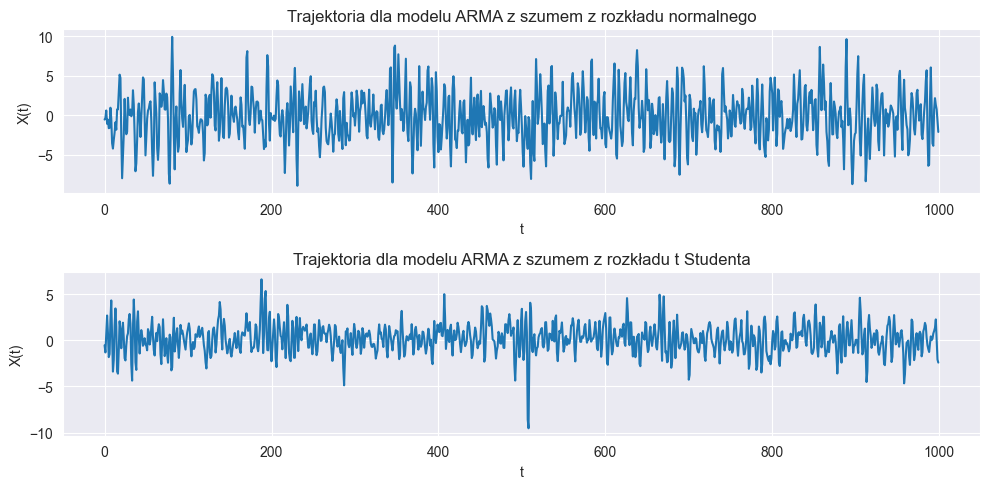

In [8]:
# Wizualizacja trajektorii

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(arma_process_trajectory)
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Trajektoria dla modelu ARMA z szumem z rozkładu normalnego')

plt.subplot(2, 1, 2)
plt.plot(arma_process_trajectory_t_distr)
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Trajektoria dla modelu ARMA z szumem z rozkładu t Studenta')

plt.tight_layout()
plt.show()

### ACF, ACVF, PACF dla ARMA(p, q)

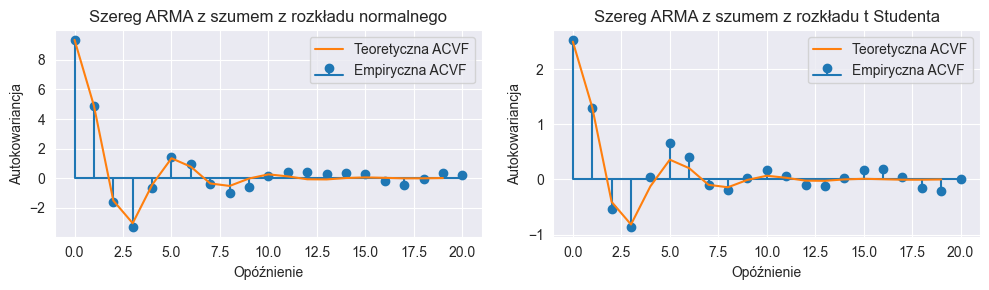

In [9]:
# Porównanie teoretycznej i empirycznej autokowariancji

h_max = 20

plt.figure(figsize=(10, 3))

# Szum z rozkładu normalnego 

plt.subplot(1, 2, 1)

autokow_teor = arma_acovf(ar_coef, ma_coef, nobs = h_max, sigma2=sigma**2)
autokow_emp = acovf(arma_process_trajectory, demean=False, fft=False, nlag=h_max)

plt.stem(autokow_emp, basefmt='', label='Empiryczna ACVF')
plt.plot(autokow_teor, '-', label='Teoretyczna ACVF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokowariancja')
plt.title('Szereg ARMA z szumem z rozkładu normalnego')
plt.legend()

plt.subplot(1, 2, 2)

# Szum z rozkładu t Studenta

autokow_teor_t = arma_acovf(ar_coef, ma_coef, nobs = h_max, sigma2 = (tau)**2*(degrees/(degrees-2)))
autokow_emp_t = acovf(arma_process_trajectory_t_distr, demean=False, fft=False, nlag=h_max)

plt.stem(autokow_emp_t, basefmt='', label='Empiryczna ACVF')
plt.plot(autokow_teor_t, '-', label='Teoretyczna ACVF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokowariancja')
plt.title('Szereg ARMA z szumem z rozkładu t Studenta')
plt.legend()

plt.tight_layout()
plt.show()

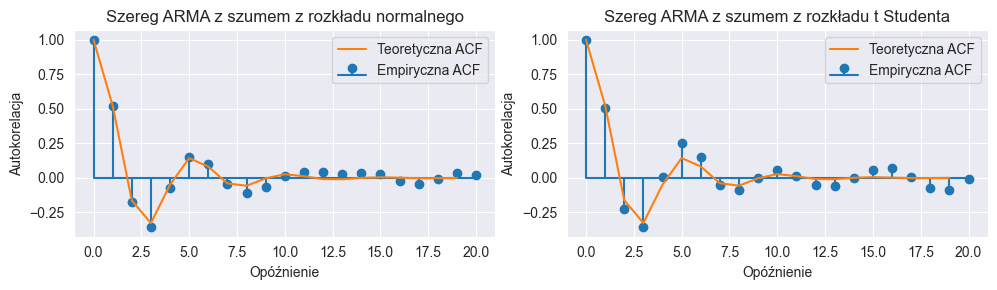

In [10]:
# Porównanie teoretycznej i empirycznej autokorelacji

h_max = 20

plt.figure(figsize=(10, 3))

# Szum z rozkładu normalnego 

plt.subplot(1, 2, 1)

acf_teor = arma_acf(ar_coef, ma_coef, lags=h_max)
acf_emp = acf(arma_process_trajectory, fft=True, nlags=h_max)

plt.stem(acf_emp, basefmt='', label='Empiryczna ACF')
plt.plot(acf_teor, '-', label='Teoretyczna ACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu normalnego')
plt.legend()

# Szum z rozkładu t-Studenta 

plt.subplot(1, 2, 2)

acf_teor_t = arma_acf(ar_coef, ma_coef, lags=h_max)
acf_emp_t = acf(arma_process_trajectory_t_distr, fft=False, nlags=h_max)

plt.stem(acf_emp_t, basefmt='', label='Empiryczna ACF')
plt.plot(acf_teor_t, '-', label='Teoretyczna ACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu t Studenta')
plt.legend()

plt.tight_layout()
plt.show()


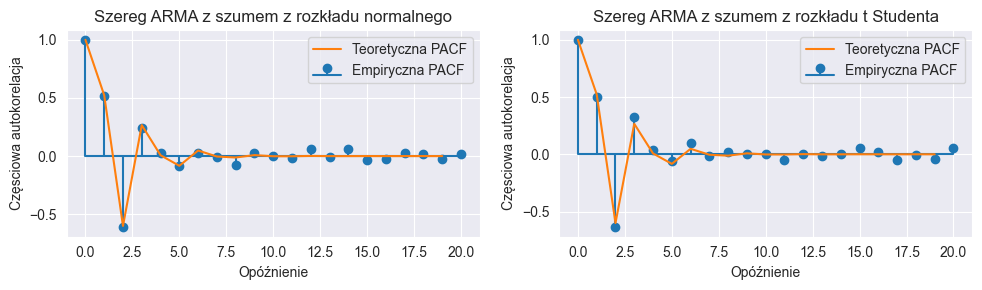

In [11]:
# Porównanie teoretycznej i empirycznej fun. częściowej autokorelacji

plt.figure(figsize=(10, 3))

# Szum z rozkładu normalnego 

plt.subplot(1, 2, 1)

acf_teor = arma_pacf(ar_coef, ma_coef, lags=h_max)
acf_emp = pacf(arma_process_trajectory, nlags=h_max, method='yw')

plt.stem(acf_emp, basefmt='', label='Empiryczna PACF')
plt.plot(acf_teor, '-', label='Teoretyczna PACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Częsciowa autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu normalnego')
plt.legend()

# Szum z rozkładu t-Studenta 

plt.subplot(1, 2, 2)

acf_teor_t = arma_pacf(ar_coef, ma_coef, lags=h_max)
acf_emp_t = pacf(arma_process_trajectory_t_distr, nlags=h_max, method='yw')

plt.stem(acf_emp_t, basefmt='', label='Empiryczna PACF')
plt.plot(acf_teor_t, '-', label='Teoretyczna PACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Częsciowa autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu t Studenta')
plt.legend()

plt.tight_layout()
plt.show()


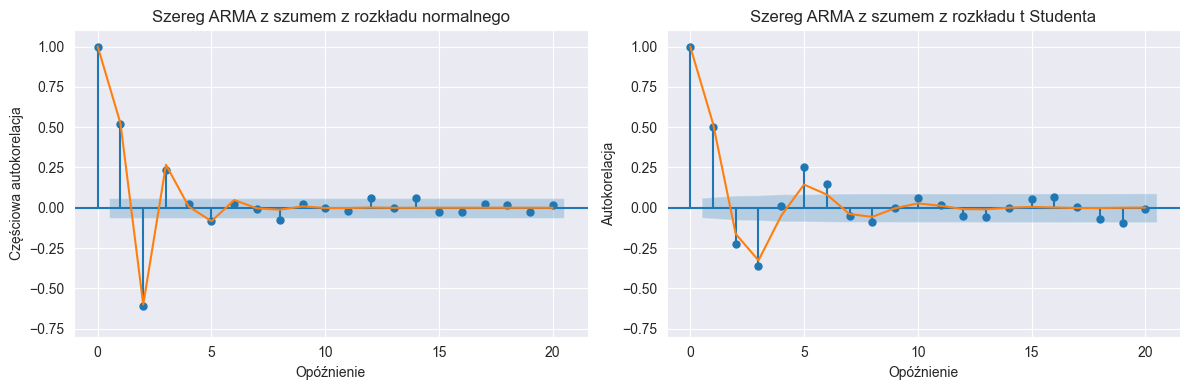

In [12]:
# Aby wyznaczyć teoretyczne wartości ACF i PAVF możemy alteratywnie skorzystać z metod acf i pacf dla wcześniej określonego obiektu "arma_process"

acf_teor_ = arma_process.acf(lags = h_max + 1) # korzystamy z funkcji arma_acf

pacf_teor_ = arma_process.pacf(lags = h_max + 1) # korzystamy z funkcji arma_pacf

# Aby obliczyć i zwizualizować empiryczne acf / pacf można tez skorzystać z funkcji plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_pacf(arma_process_trajectory, lags=h_max, ax=axes[0])
axes[0].plot(pacf_teor_)
axes[0].set_xlabel('Opóźnienie')
axes[0].set_ylabel('Częściowa autokorelacja')
axes[0].set_title('Szereg ARMA z szumem z rozkładu normalnego')
axes[0].set_ylim(-0.8, 1.1)

plot_acf(arma_process_trajectory_t_distr, lags=h_max, ax=axes[1])
axes[1].plot(acf_teor_)
axes[1].set_xlabel('Opóźnienie')
axes[1].set_ylabel('Autokorelacja')
axes[1].set_title('Szereg ARMA z szumem z rozkładu t Studenta')
axes[1].set_ylim(-0.8, 1.1)

plt.tight_layout()
plt.show()

# Aby wyznaczyć teoretyczne wartości ACVF można też skorzystać z metody acovf dla obiektu "arma_process", 
# ale wówczas zostaną wyznaczone wartości dla sigma = 1

acvf_teor_ = arma_process.acovf(nobs = h_max + 1)

### Dekompozycja szeregu czasowego - przykład 1

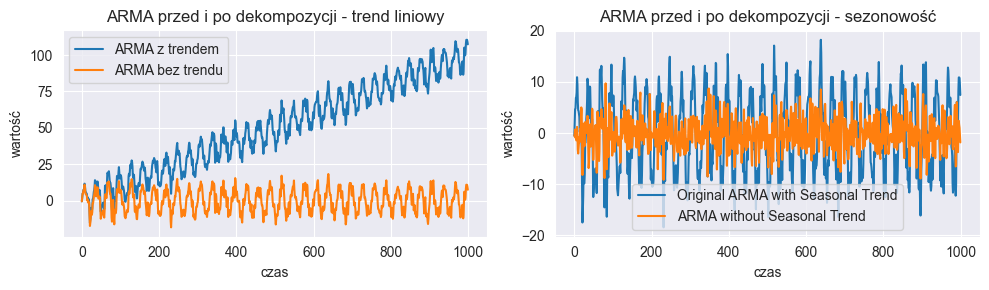

In [13]:
# Trend liniowy

trend = 0.1*np.linspace(0, len(arma_process_trajectory), len(arma_process_trajectory))

# Trend okresowy

period = 30
periodic_function = 10*np.sin(2 * np.pi * np.arange(len(arma_process_trajectory)) / period)

arma_trajectory_with_components = arma_process_trajectory + trend + periodic_function
time = np.arange(len(arma_trajectory_with_components))

# Usuwanie trendu liniowego

linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), arma_trajectory_with_components)
trend_predicted = linear_reg.predict(time.reshape(-1, 1))

arma_trajectory_without_linear_trend = arma_trajectory_with_components - trend_predicted

# Usuwanie funkcji okresowej

def sine_func(x, A, omega):
    return A * np.sin(omega * x)

p0 = [10, 2 * np.pi / 30]
params, _ = curve_fit(sine_func, time, arma_trajectory_without_linear_trend, p0=p0)
fitted_sine_wave = sine_func(time, *params)

arma_trajectory_without_seasonal = arma_trajectory_without_linear_trend - fitted_sine_wave

# Wykresy dla danych

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(arma_trajectory_with_components, label='ARMA z trendem')
axes[0].plot(arma_trajectory_without_linear_trend, label='ARMA bez trendu')
axes[0].set_xlabel('czas')
axes[0].set_ylabel('wartość')
axes[0].set_title('ARMA przed i po dekompozycji - trend liniowy')
axes[0].legend()

# Plot the original ARMA process and the ARMA process without seasonal trend
axes[1].plot(arma_trajectory_without_linear_trend, label='Original ARMA with Seasonal Trend')
axes[1].plot(arma_trajectory_without_seasonal, label='ARMA without Seasonal Trend')
axes[1].set_xlabel('czas')
axes[1].set_ylabel('wartość')
axes[1].set_title('ARMA przed i po dekompozycji - sezonowość')
axes[1].legend()

plt.tight_layout()
plt.show()


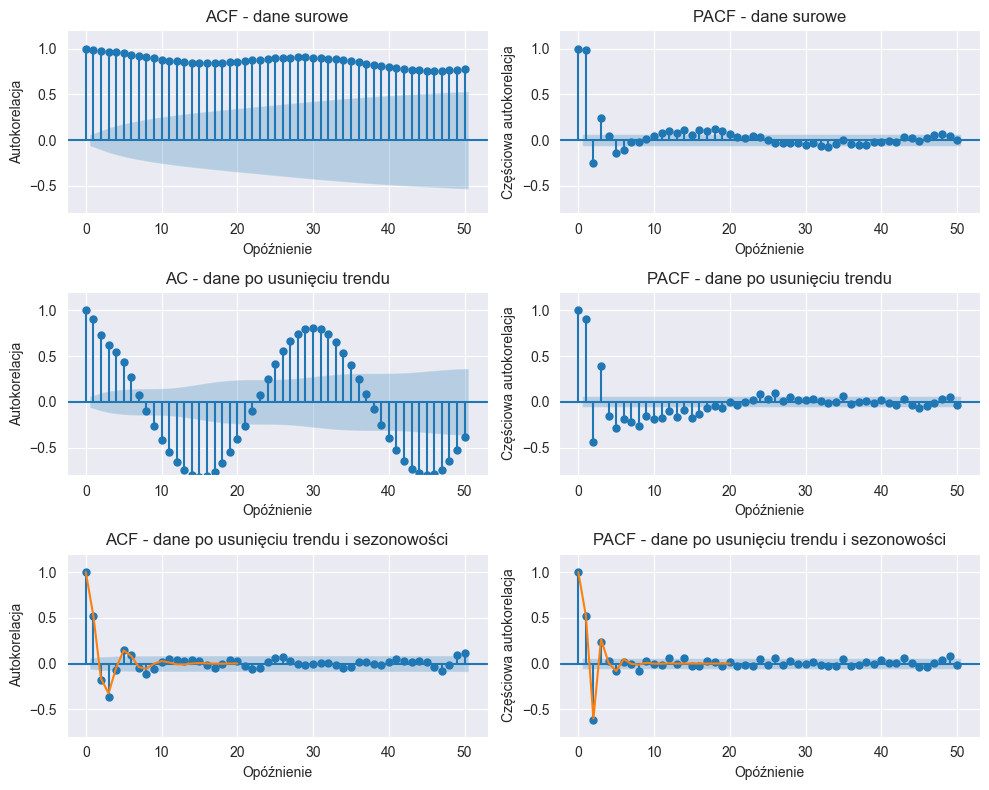

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

plot_acf(arma_trajectory_with_components, lags=50, ax=axes[0, 0])
axes[0, 0].set_xlabel('Opóźnienie')
axes[0, 0].set_ylabel('Autokorelacja')
axes[0, 0].set_title('ACF - dane surowe')
axes[0, 0].set_ylim(-0.8, 1.2)

plot_pacf(arma_trajectory_with_components, lags=50, ax=axes[0, 1])
axes[0, 1].set_xlabel('Opóźnienie')
axes[0, 1].set_ylabel('Częściowa autokorelacja')
axes[0, 1].set_title('PACF - dane surowe')
axes[0, 1].set_ylim(-0.8, 1.2)

plot_acf(arma_trajectory_without_linear_trend, lags=50, ax=axes[1, 0])
axes[1, 0].set_xlabel('Opóźnienie')
axes[1, 0].set_ylabel('Autokorelacja')
axes[1, 0].set_title('AC - dane po usunięciu trendu')
axes[1, 0].set_ylim(-0.8, 1.2)

plot_pacf(arma_trajectory_without_linear_trend, lags=50, ax=axes[1, 1])
axes[1, 1].set_xlabel('Opóźnienie')
axes[1, 1].set_ylabel('Częściowa autokorelacja')
axes[1, 1].set_title('PACF - dane po usunięciu trendu')
axes[1, 1].set_ylim(-0.8, 1.2)

plot_acf(arma_trajectory_without_seasonal, lags=50, ax=axes[2, 0])
axes[2, 0].plot(acf_teor_, '-', label='Teoretyczna ACF')
axes[2, 0].set_xlabel('Opóźnienie')
axes[2, 0].set_ylabel('Autokorelacja')
axes[2, 0].set_title('ACF - dane po usunięciu trendu i sezonowości')
axes[2, 0].set_ylim(-0.8, 1.2)

plot_pacf(arma_trajectory_without_seasonal, lags=50, ax=axes[2, 1])
axes[2, 1].plot(pacf_teor_, '-', label='Teoretyczna PACF')
axes[2, 1].set_xlabel('Opóźnienie')
axes[2, 1].set_ylabel('Częściowa autokorelacja')
axes[2, 1].set_title('PACF - dane po usunięciu trendu i sezonowości')
axes[2, 1].set_ylim(-0.8, 1.2)

plt.tight_layout()
plt.show()

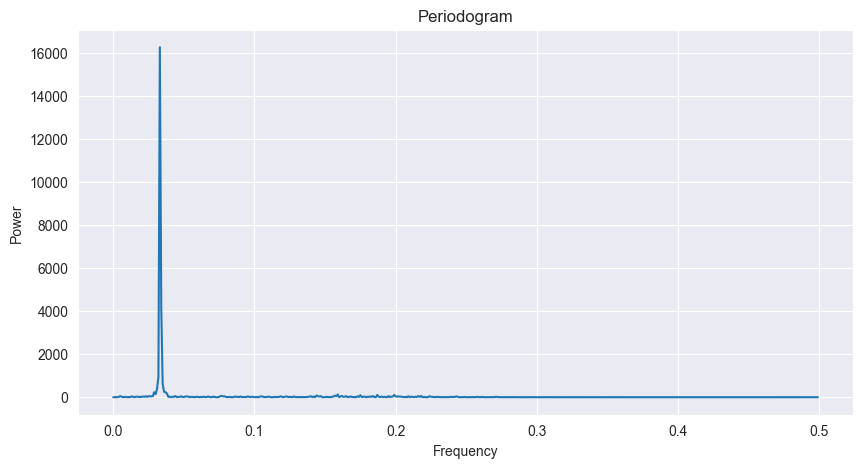

Top 5 Peaks (Frequency, Period):
Peak 1: 0.0330, 30.30
Peak 2: -0.0330, -30.30
Peak 3: -0.0340, -29.41
Peak 4: 0.0340, 29.41
Peak 5: -0.0320, -31.25
Peak 6: 0.0320, 31.25


In [15]:
# Periodogram

periodogram = np.abs(np.fft.fft(arma_trajectory_without_linear_trend))**2 / len(arma_trajectory_without_linear_trend)
frequencies = np.fft.fftfreq(len(arma_trajectory_without_linear_trend))

plt.figure(figsize=(10, 5))
plt.plot(frequencies[:len(arma_trajectory_without_linear_trend) // 2], periodogram[:len(arma_trajectory_without_linear_trend) // 2])
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

peak_indices = np.argsort(periodogram)[::-1][:6] 
peaks_frequency = frequencies[peak_indices]
peaks_period = 1 / peaks_frequency

print("Top 5 Peaks (Frequency, Period):")
for i in range(len(peaks_frequency)):
    print(f"Peak {i+1}: {peaks_frequency[i]:.4f}, {peaks_period[i]:.2f}")

### Dekompozycja szeregu czasowego - przykład 2

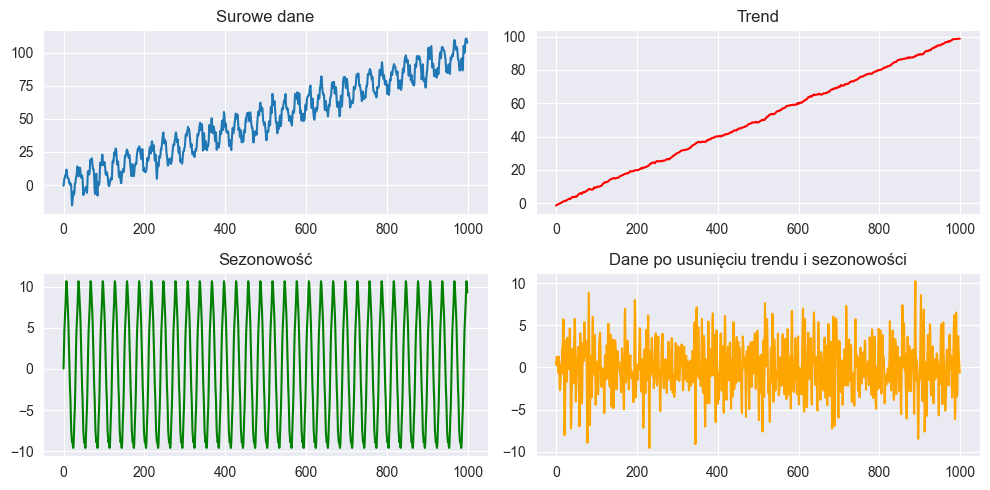

In [16]:
decomposition = seasonal_decompose(arma_trajectory_with_components, model='additive', period=30, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(arma_trajectory_with_components, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### Dekompozycja szeregu czasowego - przykład 3

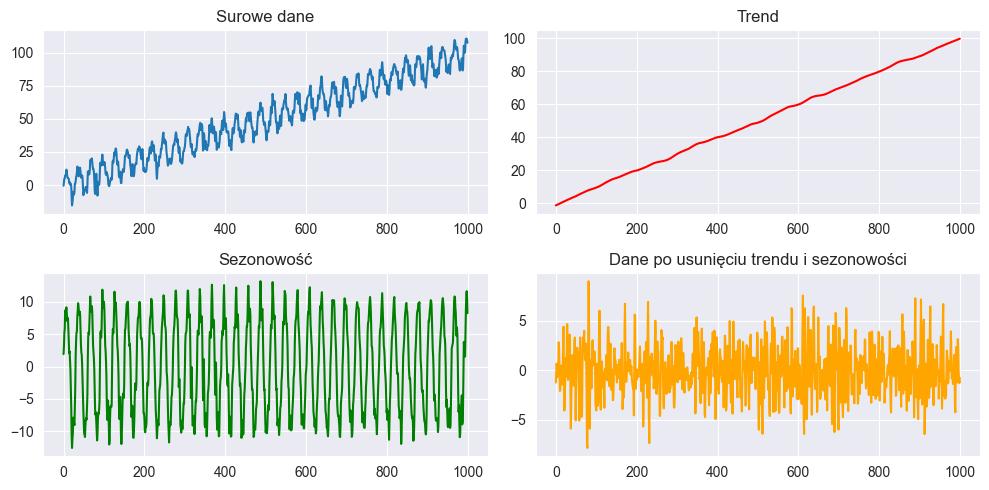

In [17]:
# https://otexts.com/fpp2/stl.html

stl_decomposition = STL(arma_trajectory_with_components, period=30).fit()

trend_stl = stl_decomposition.trend
seasonal_stl = stl_decomposition.seasonal
residual_stl = stl_decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(arma_trajectory_with_components, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_stl, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_stl, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_stl, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### Dekompozycja szeregu czasowego - przykład 4

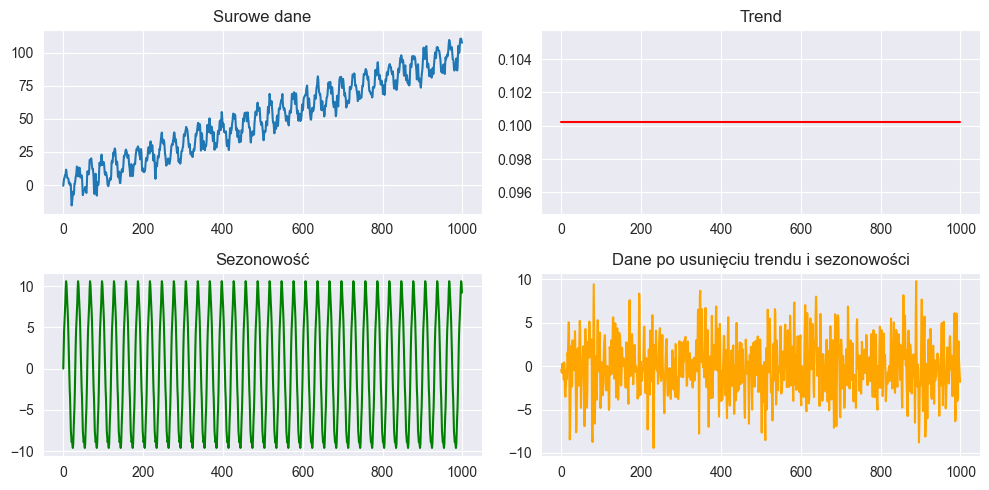

In [18]:
# https://otexts.com/fpp2/holt-winters.html

ets_model = ExponentialSmoothing(arma_trajectory_with_components, seasonal_periods=30, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend
seasonal_ets = ets_model.season
residual_ets = ets_model.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(arma_trajectory_with_components, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_ets, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_ets, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_ets, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

In [19]:
# MAE - wartości rzeczywiste vs dane po usunięciu deterministycznych komponentów

mae_without_seasonal = np.mean(np.abs(arma_process_trajectory - arma_trajectory_without_seasonal))
mae_residual = np.mean(np.abs(arma_process_trajectory - residual))
mae_residual_stl = np.mean(np.abs(arma_process_trajectory - residual_stl))
mae_residual_ets = np.mean(np.abs(arma_process_trajectory - residual_ets))

print("Metoda \t\t\t Mean Absolute Error")
print("Przykład 1\t\t", mae_without_seasonal)
print("Przykład 2\t\t", mae_residual)
print("Przykład 3\t\t", mae_residual_stl)
print("Przykład 4\t\t", mae_residual_ets)

Metoda 			 Mean Absolute Error
Przykład 1		 0.1552129630702319
Przykład 2		 0.633516145982373
Przykład 3		 1.2110441578467106
Przykład 4		 0.4279263612962421


### Testowanie stacjonarności

In [20]:
# Testowanie stacjonarności

def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")
        

In [21]:
adfuller_test(arma_process_trajectory)

Statystyka testowa = -12.154, p-Value = 0.0 => Stationary. 


In [22]:
adfuller_test(arma_process_trajectory + trend + periodic_function)

Statystyka testowa = -0.585, p-value = 0.874 => Non-stationary.


In [23]:
adfuller_test(arma_process_trajectory + trend)

Statystyka testowa = -0.68, p-value = 0.852 => Non-stationary.


In [24]:
adfuller_test(arma_process_trajectory + periodic_function) # Uwaga! W literaturze znane są testy na tzw. seasonal unit root, np. HEGY Test, CH test 

Statystyka testowa = -15.718, p-Value = 0.0 => Stationary. 


### Dopasowanie modelu, gdy p i q są znane

In [25]:
# model z szumem z rozkładu normalnego

p, q = 2, 2

model = ARIMA(arma_process_trajectory, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model.summary())

Wyniki:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2112.842
Date:                Sat, 24 Jan 2026   AIC                           4237.684
Time:                        20:25:05   BIC                           4267.130
Sample:                             0   HQIC                          4248.876
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0971      0.107     -0.908      0.364      -0.307       0.113
ar.L1          0.4349      0.057      7.697      0.000       0.324       0.546
ar.L2         -0.5256      0.035    -15.044 

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
/var/folders/md/bjv2qqp906q0tvtbwsrkfkw00000gn/T/ipykernel_24705/1550511656.py:9: SyntaxWarning: invalid escape sequence '\p'
  plt.xticks(range(len([p1, p2, q1, q2])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
/var/folders/md/bjv2qqp906q0tvtbwsrkfkw00000gn/T/ipykernel_24705/1550511656.py:9: SyntaxWarning: invalid escape sequence '\p'
  plt.xticks(range(len([p1, p2, q1, q2])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
/var/folders/md/bjv2qqp906q0tvtbwsrkfkw00000gn/T/ipykernel_24705/1550511656.py:9: SyntaxWarning: invalid escape sequence '\T'
  plt.xticks(range(len([p1, 

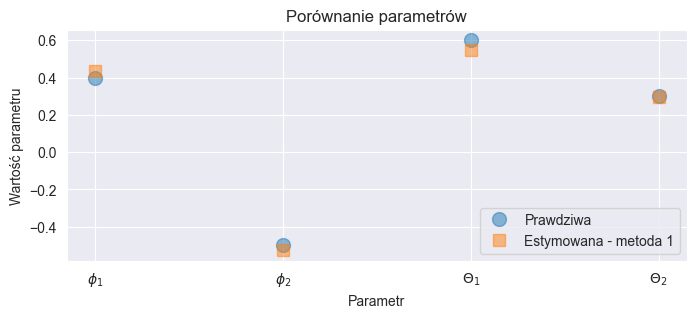

In [26]:
plt.figure(figsize=(8,3))

plt.plot([p1, p2, q1, q2], 'o', markersize=10, alpha=0.5, label='Prawdziwa')
plt.plot(model.params[1:-1], 's', markersize=8, alpha=0.5, label='Estymowana - metoda 1')
plt.legend()
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')
plt.xticks(range(len([p1, p2, q1, q2])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])

plt.show()

In [27]:
# model z szumem z rozkładu t Studenta

p, q = 2, 2

model_first_method = ARIMA(arma_process_trajectory_t_distr, order=(p, 0, q)).fit(method='statespace')
model_second_method = ARIMA(arma_process_trajectory_t_distr, order=(p, 0, q)).fit(method='innovations_mle')
model_third_method = ARIMA(arma_process_trajectory_t_distr, order=(p, 0, q)).fit(method='hannan_rissanen')

print("Wyniki dla method='statespace':\n")
print(model_first_method.summary())
print("\n")
print("Wyniki dla method='innovations_mle':\n")
print(model_second_method.summary())
print("\n")
print("Wyniki dla method='hannan_rissanen':\n")
print(model_third_method.summary())

Wyniki dla method='statespace':

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1410.790
Date:                Sat, 24 Jan 2026   AIC                           2833.579
Time:                        20:25:06   BIC                           2863.026
Sample:                             0   HQIC                          2844.771
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1717      0.054      3.182      0.001       0.066       0.277
ar.L1          0.4077      0.051      7.975      0.000       0.308       0.508
ar.L2         -0.55

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\T'
/var/folders/md/bjv2qqp906q0tvtbwsrkfkw00000gn/T/ipykernel_24705/819244807.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.xticks(range(len([p1, p2, q1, q2])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
/var/folders/md/bjv2qqp906q0tvtbwsrkfkw00000gn/T/ipykernel_24705/819244807.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.xticks(range(len([p1, p2, q1, q2])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
/var/folders/md/bjv2qqp906q0tvtbwsrkfkw00000gn/T/ipykernel_24705/819244807.py:11: SyntaxWarning: invalid escape sequence '\T'
  plt.xticks(range(l

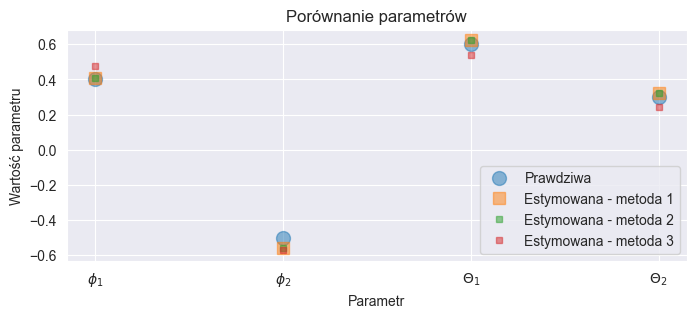

In [28]:
plt.figure(figsize=(8,3))

plt.plot([p1, p2, q1, q2], 'o', markersize=10, alpha=0.5, label='Prawdziwa')
plt.plot(model_first_method.params[1:-1], 's', markersize=8, alpha=0.5, label='Estymowana - metoda 1')
plt.plot(model_second_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 2')
plt.plot(model_third_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 3')
plt.legend()
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')
plt.xticks(range(len([p1, p2, q1, q2])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])

plt.show()

### Residua modelu

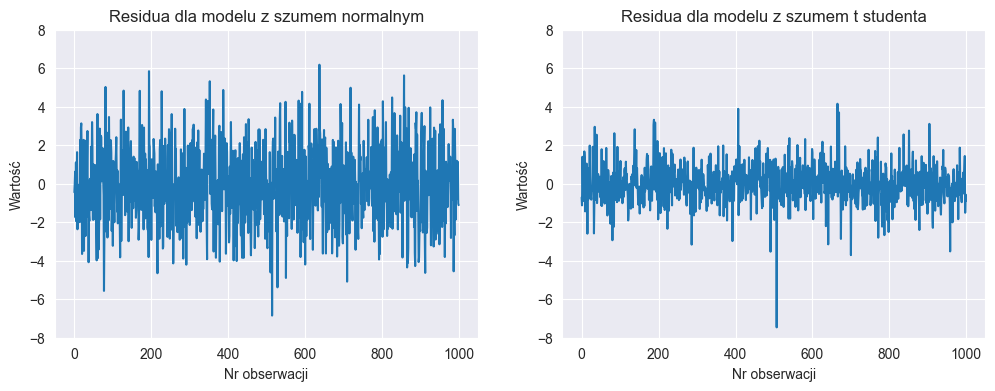

In [29]:
# Wyznaczanie residuów na podstawie dopasowanego modelu
resid_normal = model.resid

resid_t_dist = model_first_method.resid

# Plot the residuals
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(resid_normal)
plt.title('Residua dla modelu z szumem normalnym')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-8, 8])

plt.subplot(1, 2, 2)
plt.plot(resid_t_dist)
plt.title('Residua dla modelu z szumem t studenta')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-8, 8])

plt.show()


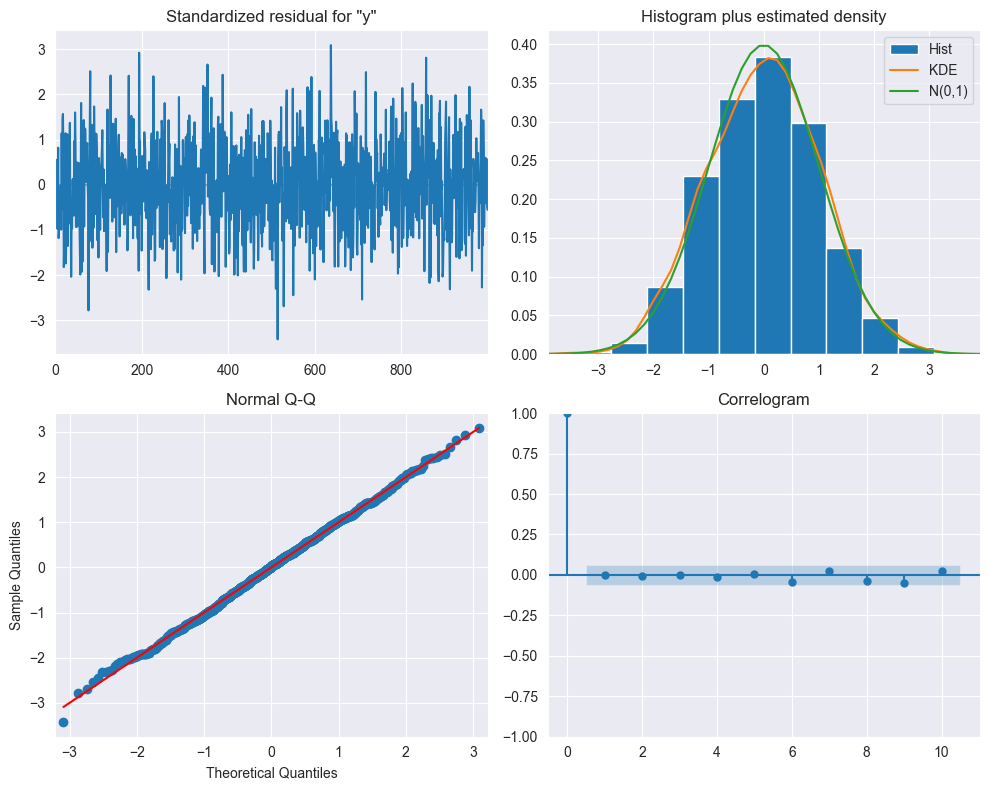

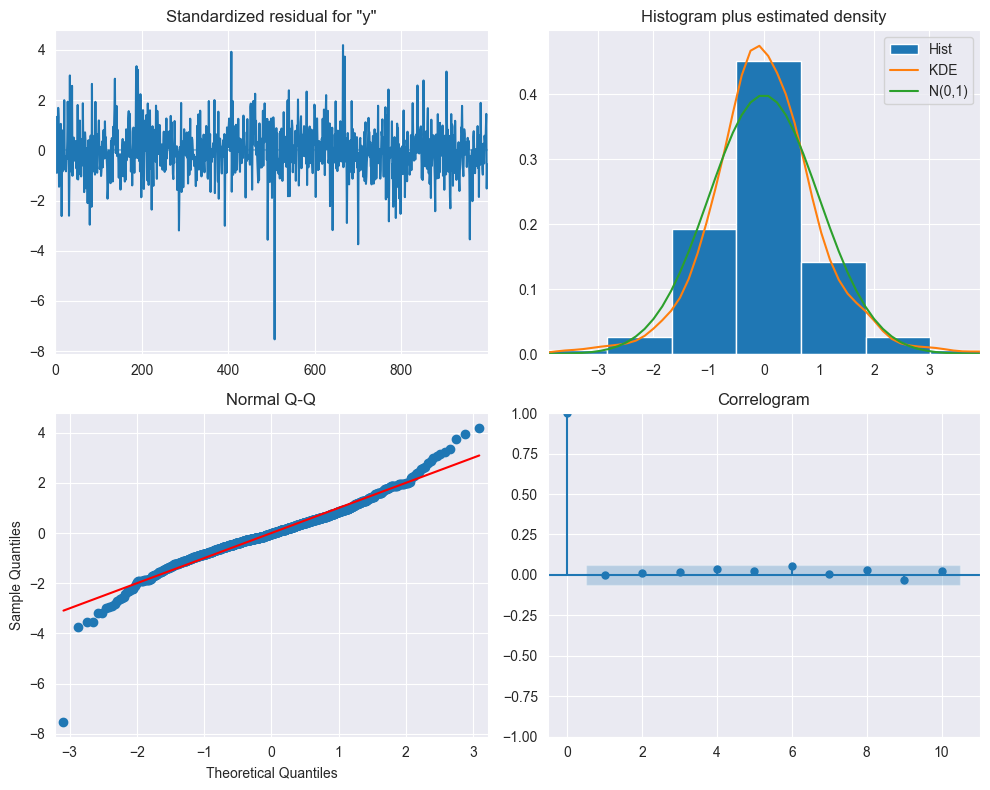

In [30]:
# Wbudowana funkcja do podstowej diagnostyki modelu
model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

model_first_method.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

### Znajdownanie rzędu modelu (p, q) za pomocą kryteriów informacyjnych

In [31]:
# Za pomocą kryteriow informacyjnych szukamy rzędu modelu, rozważamy ARMA(p,q), gdzie p, q = {0, 1, 2, 3}

df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 3
max_q = 3

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(arma_process_trajectory, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC


In [32]:
df.sort_values(by='AIC').head(1)

,p,q,AIC,BIC,HQIC
8,2,2,4237.68385,4267.130381,4248.875586


In [33]:
df.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC
8,2,2,4237.68385,4267.130381,4248.875586


In [34]:
df.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
8,2,2,4237.68385,4267.130381,4248.875586


# Pakiet: pmdarima

Uwaga! Domyślnie do znalezienia optymalnego rzędu funkcja auto_arima wykorzystuje algorytm krokowy opisany w Hyndman i Khandakar (2008).

In [35]:
model1 = pm.auto_arima(arma_process_trajectory, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5, 
                       max_q=5, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = True)

print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5076.547, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4764.571, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4481.084, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4432.750, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4256.763, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4300.285, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4246.111, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4244.491, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4245.850, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4244.882, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4245.682, Time=0.04 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.349 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1

In [36]:
model2 = pm.auto_arima(arma_process_trajectory, 
                       d=0,
                       start_p=1,
                       start_q=4,
                       max_d=0,
                       max_p=5, 
                       max_q=5, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = True)

print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4248.807, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5076.547, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4764.571, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4481.084, Time=0.02 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4247.009, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4341.996, Time=0.03 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=4248.675, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4301.090, Time=0.04 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=4249.752, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=4247.966, Time=0.06 sec

Best model:  ARIMA(0,0,4)(0,0,0)[0]          
Total fit time: 0.447 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 0, 4)   Log Likelihood        

In [37]:
model3 = pm.auto_arima(arma_process_trajectory, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5, 
                       max_q=5, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = False)

print(model3.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5076.547, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4481.084, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4350.580, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4341.996, Time=0.03 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4247.009, Time=0.03 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=4248.675, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4764.571, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4432.750, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4350.242, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4301.090, Time=0.04 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4248.807, Time=0.05 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=4249.752, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4300.285, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4256.763, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4236.510, Time=0.03 sec
 ARIMA(2,0

### Do poczytania:

https://alkaline-ml.com/pmdarima/tips_and_tricks.html#tips-and-tricks

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.kaggle.com/code/purvasingh/time-series-analysis-with-arma-and-arima

### O przykładowej bibliotece w Julii:
https://lost-stats.github.io/Time_Series/ARIMA-models.html